# Baum-Welch Algorithm (Casino data)


## Python Imports

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Generate data

In [90]:
def GenerateDiceData(seq_len):
  DiceRoll = []
  dice_state = []
  current_state = np.random.choice([0, 1])
  
  for i in range(0, seq_len):  
    dice_state.append(current_state)
    if current_state == 0:
      roll = np.random.choice(np.arange(0, 6), p=[1./6, 1./6, 1./6, 1./6, 1./6, 1./6])
      DiceRoll.append(roll)
      current_state = np.random.choice([0,1], p = [0.95, 0.05])
    elif current_state == 1:
      roll = np.random.choice(np.arange(0, 6), p=[1./10, 1./10, 1./10, 1./10, 1./10, 5./10])
      DiceRoll.append(roll)
      current_state = np.random.choice([0,1], p = [0.1, 0.9])
  return DiceRoll, dice_state

In [91]:
num_sequence = 300
seq_len = 40

encoded_list = []
for i in range(num_sequence):
  seq,_ = GenerateDiceData(seq_len)
  encoded_list.append(seq)

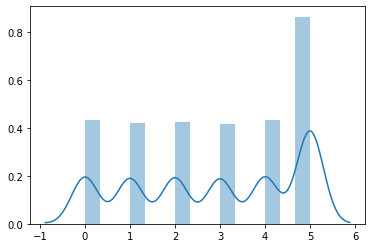

In [92]:
sns.distplot(encoded_list)

## Encode sequence as integers (index values)

In [93]:
def encode(sequence, symbols):
    
    enc = [0] * len(sequence)
    
    for i in range(len(sequence)):
        enc[i] = symbols.find(sequence[i])
    
    return(enc)

In [94]:
def normalize(v):
    norm = np.sum(v)
    v = v/norm
    return (v, norm)

## Forward Loop

In [95]:
def initialize_forward(input_encode, states, initial_prob, emission_probs):
    
    alpha = np.zeros(shape=(states, len(input_encode)))
        
    for i in range(0, states): 
        
        alpha[i][0] = initial_prob[i]*emission_probs[i][input_encode[0]]
        
    return alpha

In [96]:
def run_forward(input_encode, states, initial_prob, emission_probs):

    alpha = initialize_forward(input_encode, states, initial_prob, emission_probs)
    norm_vector = np.zeros(len(input_encode))
    alpha[:,0], norm_vector[0] = normalize(alpha[:,0])


    for i in range(1, len(input_encode)):
        
        for j in range(0, states):

            _sum = 0
            
            for k in range(0, states):
                
                _sum += alpha[k][i-1] * transition_matrix[k,j] 
      
            # store prob
            alpha[j][i] = emission_probs[j][input_encode[i]] * _sum

        # Normalize
        alpha[:,i],norm_vector[i] = normalize(alpha[:,i])

    return alpha, norm_vector

## Backward Loop

In [97]:
def initialize_backward(input_encode, states):
  
    
    beta = np.zeros(shape=(states, len(input_encode)))
        
    for i in range(0, states):
  
        beta[i][-1] = 1
        
    return beta

In [98]:
def run_backward(input_encode, states, emission_probs, transition_matrix, norm_vector):

    beta = initialize_backward(input_encode, states)

    for t in range(len(input_encode)-2, -1 , -1):
      for i in range(states):

            _sum = 0

            for j in range(states):
              _sum += beta[j][t+1] * transition_matrix[i][j] * emission_probs[j][input_encode[t+1]]
                
            # store prob
            beta[i][t] = _sum

      beta[:,t] = beta[:,t] / norm_vector[t]

    return beta

##Load sequences

In [99]:
symbols = "012345"

max_seq_length = seq_len
V = len(symbols)

##Implementaion of Baum-Welsh

In [100]:
states = 2
num_iters = 150

initial_prob = [1.0/states, 1.0/states]

transition_matrix = np.asarray([0.5, 0.05, 0.5, 0.5]).reshape(2,2)

fair_prob = [1.0/6, 1./6, 1./6, 1./6, 1./6, 1./6]
loaded_prob = [1./10, 1./10, 1./10, 1./10, 1./10, 5./10] 
emission_probs = [fair_prob, loaded_prob]

for iteration in range(num_iters):
  print('Starting iteration ', iteration)
    
  # Initiate xi
  xi = np.zeros(max_seq_length*states*states*num_sequence).reshape(states,states,max_seq_length,num_sequence)

  gamma = np.zeros(max_seq_length*states*num_sequence).reshape(states,max_seq_length,num_sequence)
  gamma_sums = np.zeros(max_seq_length*states*num_sequence).reshape(states,max_seq_length,num_sequence)

  for r in range(num_sequence):

    # Load and encode sequence
    input_encode = encoded_list[r] 
    T = len(input_encode)

    # Calculate alpha and beta matrix
    alpha, norm_vector = run_forward(input_encode, states, initial_prob, emission_probs)
    beta = run_backward(input_encode, states, emission_probs, transition_matrix, norm_vector)

    for i in range(states):
      for t in range(T-1):
        for j in range(states):

          # Calculate denominator
          gamma_sums[i][t][r] += alpha[j][t] * beta[j][t]
          # Calculate Xi
          
          # Summation of denominator of xi
          xi_denominator = 0

          for k in range(states):
            for w in range(states):

              # check that transition matrix is defined correct?
              xi_denominator += alpha[k][t] * transition_matrix[k][w] * beta[w][t+1] * emission_probs[w][input_encode[t+1]]

          # Calculate xi
          xi[i][j][t][r] = (alpha[i][t] * transition_matrix[i][j] * beta[j][t+1] * emission_probs[j][input_encode[t+1]]) / xi_denominator # Check this

        gamma[i][t][r] = (alpha[i][t] * beta[i][t]) / gamma_sums[i][t][r]


  # Update of parameters
  for i in range(states):

    # Update initial probabilities
    initial_prob[i] = 0
    for r in range(num_sequence):
      initial_prob[i] += gamma[i][1][r] / num_sequence

    for j in range(states):

      # Update transition matrix
      xi_sum = 0
      gamma_sum = 0

      for r in range(num_sequence):
        T = len(encoded_list[r]) 
        for t in range(T-1):
        
          xi_sum += xi[i][j][t][r]
          gamma_sum += gamma[i][t][r]
      
      transition_matrix[i][j] = xi_sum / gamma_sum
      
      # Update emission probs
      for k in range(V):
        denominator_sum = 0
        numerator_sum = 0
        for r in range(num_sequence):
          T = len(encoded_list[r]) 
          for t in range(T):
          
            denominator_sum += gamma[i][t][r]
        
            if encoded_list[r][t] == k:
              numerator_sum += gamma[i][t][r]
          
        emission_probs[i][k] = numerator_sum / denominator_sum

  
  # Normalize transition
  for row in range(states):
    summ = sum(transition_matrix[row])
    for col in range(states):
      transition_matrix[row][col] = transition_matrix[row][col] / summ
  
  # Normalize emission
  for row in range(states):
    summ = sum(emission_probs[row])
    for col in range(V):
      emission_probs[row][col] = emission_probs[row][col] / summ  

print('iteration: ', iteration)
print('Initial probabilities: ')
print(initial_prob)
print('Normalized transition matrix')
print(transition_matrix)
print('Normalized Emission probabilities')
print(emission_probs)
      

Starting iteration  0
Starting iteration  1
Starting iteration  2
Starting iteration  3
Starting iteration  4
Starting iteration  5
Starting iteration  6
Starting iteration  7
Starting iteration  8
Starting iteration  9
Starting iteration  10
Starting iteration  11
Starting iteration  12
Starting iteration  13
Starting iteration  14
Starting iteration  15
Starting iteration  16
Starting iteration  17
Starting iteration  18
Starting iteration  19
Starting iteration  20
Starting iteration  21
Starting iteration  22
Starting iteration  23
Starting iteration  24
Starting iteration  25
Starting iteration  26
Starting iteration  27
Starting iteration  28
Starting iteration  29
Starting iteration  30
Starting iteration  31
Starting iteration  32
Starting iteration  33
Starting iteration  34
Starting iteration  35
Starting iteration  36
Starting iteration  37
Starting iteration  38
Starting iteration  39
Starting iteration  40
Starting iteration  41
Starting iteration  42
Starting iteration  4

# Viterbi - Run on one sequence

In [101]:
# Generate test data
num_sequence = 100
seq_len = 40

test_list = []
target_list = []
for i in range(num_sequence):
  seq, tar = GenerateDiceData(seq_len)
  test_list.append(seq)
  target_list.append(tar)

In [102]:
def initialize(encode_sequence, states, initial_prob, transition_matrix, emission_probs):
    
    delta = np.zeros(shape=(states, len(encode_sequence)))
    
    arrows = np.ndarray(shape=(states, len(encode_sequence)), dtype=object)
    
    # initial conditions
    for i in range(0, states):

	## delta[i][0] = XX  
        delta[i][0] = initial_prob[i] + emission_probs[i][encode_sequence[0]]
    
        arrows[i][0] = 0
    
    return delta, arrows

In [103]:
# Loop for calculating accuracy
from sklearn.metrics import accuracy_score

accuracies = []

for seq_id in range(num_sequence):

  input_encode = test_list[seq_id]

  delta, arrows = initialize(input_encode, states, initial_prob, transition_matrix, emission_probs)

  # main loop
  for i in range(1, len(input_encode)):
      
      for j in range(0, states):
          
          max_arrow_prob = -np.inf
          max_arrow_prob_state = -1
          
          for k in range(0, states):
            
        # arrow_prob = XX 
              arrow_prob = delta[k][i-1] + transition_matrix[k, j]
              
              if arrow_prob > max_arrow_prob: 
      # max_arrow_prob = XX
                  max_arrow_prob = arrow_prob
                  # max_arrow_prob_state = XX
                  max_arrow_prob_state = k
              
          # store prob
    # delta[j][i] = XX + max_arrow_prob
          delta[j][i] = emission_probs[j][input_encode[i]] + max_arrow_prob

          # store arrow
          arrows[j][i] = max_arrow_prob_state

  path = []

  max_state = np.argmax(delta[:, -1])
  max_value = delta[max_state, -1]

  path.append(int(max_state))

  old_state = max_state

  for i in range(len(input_encode)-2, -1, -1):
    
    # current_state = arrows[XX][i+1]
    current_state = arrows[old_state][i+1]
    path.append(int(current_state))

    old_state = current_state 

  path.reverse()
  accuracies.append(accuracy_score(np.array(list(path)), np.array(target_list[seq_id])))

print('Accuracy on test data:', np.mean(accuracies))

Accuracy on test data: 0.7722499999999998
